# 2024 Fall ENEL 645 - Assignment 2
# Team: ENEL 645 L01 - 8
## Garbage classification 

Class Distribution in Training Dataset:<br>
<img title="Class Distribution in Training Dataset" alt="Alt text" src="Class Distribution in Training Dataset.png"> 

Class Distribution in Validation Dataset:<br>
<img title="Class Distribution in Validation Dataset" alt="Alt text" src="Class Distribution in Validation Dataset.png"> 

Class Distribution in Test Dataset:<br>
<img title="Class Distribution in Test Dataset" alt="Alt text" src="Class Distribution in Test Dataset.png">

Sample Token Length Distribution (Dataset Initialization):<br>
<img title="Sample Token Length Distribution (Dataset Initialization)" alt="Alt text" src="Sample Token Length Distribution (Dataset Initialization).png">

Training and Validation Metrics Before and After Unfreeze:<br>
<img title="Training_and_Validation_Metrics_Before_and_After_Unfreeze" alt="Alt text" src="Training_and_Validation_Metrics_Before_and_After_Unfreeze.png">

Confusion Matrix:<br>
<img title="confusion_matrix" alt="Alt text" src="confusion_matrix.png">

Import required Library

In [1]:
# import libraries
import datetime
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import pandas as pd
import seaborn as sns
import random
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from transformers import DistilBertModel, DistilBertTokenizer
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms


/home/jeffrey.wong1/software/miniforge3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define training set, validation set and testing set

In [ ]:
# define detaset paths
TRAIN_PATH  = "/work/TALC/enel645_2024f/garbage_data/CVPR_2024_dataset_Train"
VAL_PATH    = "/work/TALC/enel645_2024f/garbage_data/CVPR_2024_dataset_Val"
TEST_PATH   = "/work/TALC/enel645_2024f/garbage_data/CVPR_2024_dataset_Test"

# TRAIN_PATH = "/home/tommy.li1/Git/ENGL645_Fall_2024_Proj/Assignment2/Data/CVPR_2024_dataset_Train"
# VAL_PATH = "/home/tommy.li1/Git/ENGL645_Fall_2024_Proj/Assignment2/Data/CVPR_2024_dataset_Val"
# TEST_PATH = "/home/tommy.li1/Git/ENGL645_Fall_2024_Proj/Assignment2/Data/CVPR_2024_dataset_Test"

# define hyperparameters
fc_hidden_sizes = [1024, 512]
target_size     = 512  # Assuming target size is 512 for both text and image
dropout_rate    = 0.21336996121007903
brench_size     = 24
max_len         = 300

Utility Function for importing data and displaying result

In [ ]:
def get_image_paths(directory):
    """
    Collects and returns a list of file paths for images in a directory, 
    assuming images are organized in subfolders by class.
    Parameters:
    directory (str): The path to the main directory containing class subdirectories with images.
    Returns:
    list: A list of file paths for each image found in the class subdirectories.
    """
    
    image_paths = [] # Initialize an empty list to store image file paths
    class_folders = sorted(os.listdir(directory)) # Get a sorted list of subdirectory names
    # Iterate over each subdirectory
    for class_name in class_folders:
        class_path = os.path.join(directory, class_name) # Full path to the class folder
        
        # Check if the path is a directory to ensure it's a class folder
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path) # List all files in the class folder
            
            # Iterate over each file in the class folder
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name) # Full path to the file
                
                # Check if it's a file (not a directory) and add it to the list
                if os.path.isfile(file_path):
                    image_paths.append(file_path)
    
    return image_paths # Return the list of image file paths

def read_text_files_with_labels(path):
    """
    Reads text data and labels from subdirectories in the specified path.
    Each subdirectory represents a class, and files within each class directory are 
    converted into text data (with any digits removed) and assigned a label based on 
    the class folder.
    Parameters:
    path (str): The root directory path containing class folders with text files.
    Returns:
    tuple: Two numpy arrays, `texts` and `labels`.
           - `texts` (numpy array): An array of processed text strings derived from file names.
           - `labels` (numpy array): An array of integer labels corresponding to each text, 
             where labels are mapped based on the alphabetical order of class folders.
    """
    
    texts   = [] # Initialize list to store processed text data
    labels  = [] # Initialize list to store labels for each text
    class_folders = sorted(os.listdir(path))  # Get a sorted list of class folder names
    
    # Create a mapping from class name to a numeric label based on alphabetical order
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    # Iterate through each class folder to read and label text files
    for class_name in class_folders:
        class_path = os.path.join(path, class_name)# Full path to the class folder
        
        # Check if the path is a directory (representing a class)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path) # List all files in the class folder
            
            # Process each file within the class folder
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)# Full path to the file
                
                # Check if it's a file (not a directory)
                if os.path.isfile(file_path):
                    # Remove the file extension and replace underscores with spaces
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')

                    # Remove any digits from the text
                    text_without_digits = re.sub(r'\d+', '', text)

                    # Append processed text and corresponding label to lists
                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])

    # Convert lists to numpy arrays for consistency and efficient processing
    return np.array(texts), np.array(labels)

def count_class_instances(labels):
    """
    Counts the occurrences of each unique label in the provided list or array.
    Parameters:
    labels (array-like): A list or array of labels (e.g., integers or strings) 
                         where each label represents a class.
    Returns:
    dict: A dictionary with unique labels as keys and their corresponding 
          counts as values.
    """

    # Get unique labels and their counts from the array
    unique_labels, counts = np.unique(labels, return_counts=True)

    # Create a dictionary to map each unique label to its count
    return dict(zip(unique_labels, counts))

def plot_class_distribution(class_counts, dataset_name):
    """
    Plots a bar chart showing the distribution of class instances in a dataset.
    Parameters:
    class_counts (dict): A dictionary where keys are class labels and values are the counts of each class.
    dataset_name (str): The name of the dataset, used in the title and file name of the plot.
    Returns: None
    """
    
    # Extract class labels and their counts from the dictionary
    classes = list(class_counts.keys())
    counts  = list(class_counts.values())

    # Set up the figure size for the plot
    plt.figure(figsize=(10, 6))
    # Create a bar chart of class counts
    plt.bar(classes, counts, color='skyblue')
    # Set the labels for the x-axis and y-axis
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Instances")
    # Set the title of the plot, including the dataset name
    plt.title(f"Class Distribution in {dataset_name} Dataset")
    # Ensure class labels are shown on the x-axis
    plt.xticks(classes)
    # Save the plot as a PNG file with a name based on the dataset name
    plt.savefig(f"Class Distribution in {dataset_name} Dataset.png")
    # Display the plot
    plt.show()

def plot_all_class_distribution(labels_train, labels_val, labels_test):
    """
    Plots the class distributions for training, validation, and test datasets.
    Parameters:
    labels_train (array-like): Labels for the training dataset.
    labels_val (array-like): Labels for the validation dataset.
    labels_test (array-like): Labels for the test dataset.
    Returns: None
    """
    # Count instances for training, validation, and test dataset using the count_class_instances function
    train_class_counts  = count_class_instances(labels_train)
    val_class_counts    = count_class_instances(labels_val)
    test_class_counts   = count_class_instances(labels_test)

    # Plot class distribution for the training dataset
    plot_class_distribution(train_class_counts, "Training")
    # Plot class distribution for the validation dataset
    plot_class_distribution(val_class_counts,   "Validation")
    # Plot class distribution for the test dataset
    plot_class_distribution(test_class_counts,  "Test")

def denormalize_image(image_tensor, mean, std):
    """
    De-normalize the image tensor using given mean and std.
    This function undoes the normalization step applied during image preprocessing.
    It scales the image back to its original range using the mean and standard deviation 
    values that were used during normalization.
    Parameters:
    - image_tensor (Tensor): The normalized image tensor (after being processed).
    - mean (list or tuple): The mean values used during normalization for each channel (e.g., [0.485, 0.456, 0.406]).
    - std (list or tuple): The standard deviation values used during normalization for each channel (e.g., [0.229, 0.224, 0.225]).
    Returns:
    - Tensor: The denormalized image tensor.
    """
    # Clone the image tensor to prevent modification of the original tensor
    image_tensor = image_tensor.clone() 
    # Loop over each channel (R, G, B) in the image tensor
    for t, m, s in zip(image_tensor, mean, std):
        # Denormalize each channel: undo the normalization using the formula:
        # denormalized_value = (normalized_value * std) + mean
        t.mul_(s).add_(m)  # In-place multiplication and addition to denormalize
    return image_tensor

def evaluate_classification_metrics(true_labels, predictions, class_names, filename="confusion_matrix.png"):
    """
    Evaluates and prints classification metrics, and saves a confusion matrix plot.
    Parameters:
    true_labels (array-like): True labels of the dataset.
    predictions (array-like): Predicted labels by the classifier.
    class_names (list of str): Names of the classes, used for labeling the confusion matrix.
    filename (str, optional): The filename to save the confusion matrix plot. Defaults to "confusion_matrix.png".
    Returns: None
    """
    # Calculate key classification metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Print out the calculated metrics with 4 decimal precision
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    
    # Display detailed classification report
    print("\nClassification Report:\n")
    print(classification_report(true_labels, predictions, target_names=class_names))

    # Generate and plot the confusion matrix
    cm = confusion_matrix(true_labels, predictions) # Confusion matrix array
    plt.figure(figsize=(10, 8)) # Set the figure size for the plot

    # Plot the confusion matrix as a heatmap with annotations
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=class_names, yticklabels=class_names)

    # Set plot title and axis labels for clarity
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Save the confusion matrix plot to a file
    plt.savefig(filename)
    plt.close() # Close the plot to free memory

def plot_token_length_distribution(token_lengths, title="Token Length Distribution"):
    """
    Plots a histogram showing the distribution of token lengths.
    Parameters:
    token_lengths (array-like): A list or array of token lengths to be plotted.
    title (str, optional): The title of the plot, used as the plot title and file name. Defaults to "Token Length Distribution".
    Returns: None
    """

    # Set the figure size for the plot
    plt.figure(figsize=(10, 6))

    # Create a histogram of token lengths with a kernel density estimate (KDE)
    sns.histplot(token_lengths, bins=20, kde=True)

    # Set labels for the x-axis and y-axis
    plt.xlabel("Token Length")
    plt.ylabel("Frequency")

    # Set the title of the plot
    plt.title(title)

    # Save the plot as a PNG file with the title as the filename
    plt.savefig(title+".png")

    # Display the plot
    plt.show()

Image model feature extractor

In [ ]:
# Define a feature extractor class using a pre-trained ResNet-18 model
class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        """
        Initializes the feature extractor using a pre-trained ResNet-18 model.
        The last fully connected layer is removed to output the feature map.
        """
        super(ResNetFeatureExtractor, self).__init__()
        # Load the pre-trained ResNet-18 model with ImageNet weights
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Remove the final fully connected layer (classifier) to extract features
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])

    def forward(self, images, train_feature_extractor=False):
        """
        Forward pass for feature extraction. It returns the feature vector of images.
        Parameters:
        images (Tensor): A batch of input images.
        train_feature_extractor (bool): Flag to control whether to train the feature extractor.
            If True, the feature extractor will be trained; otherwise, gradients are not computed.
        Returns:
        Tensor: The extracted feature vector from the image batch.
        """
        if train_feature_extractor:
            # If training the feature extractor, compute features and keep gradients
            features = self.feature_extractor(images).squeeze(-1).squeeze(-1)
        else:
            # If not training, freeze the feature extractor (no gradients)
            with torch.no_grad():
                features = self.feature_extractor(images).squeeze(-1).squeeze(-1)
        return features

Define Mulitmodal dataset concat image and text

In [ ]:

class MultiModalDataset(Dataset):
    """
    A custom dataset class for handling multi-modal data (text and images). It combines text data and corresponding
    image paths, applies tokenization to the text, and applies transformations to the images.
    Parameters:
    - texts (list of str): A list of text samples.
    - labels (list of int): A list of labels corresponding to the texts.
    - image_paths (list of str): A list of file paths to the images.
    - tokenizer (transformers.BertTokenizer): The tokenizer to process the text data.
    - max_len (int): The maximum length for the tokenized text.
    - image_transform (callable): A transformation to be applied to the images (e.g., normalization).
    """
    def __init__(self, texts, labels, image_paths, tokenizer, max_len, image_transform):
        # Initialize the dataset with texts, labels, image paths, tokenizer, max length, and image transformations
        self.texts           = [str(text) for text in texts] # Ensure texts are strings
        self.labels          = labels
        self.image_paths     = image_paths
        self.tokenizer       = tokenizer
        self.max_len         = max_len
        self.image_transform = image_transform

        # Sampling a subset of texts for visualization (e.g., 100 random samples)
        sample_size  = min(100, len(self.texts))
        sample_texts = random.sample(self.texts, sample_size)

        # Calculate token lengths for visualization
        token_lengths = [
            len(self.tokenizer(text, truncation=True, max_length=self.max_len, return_tensors="pt")["input_ids"][0]) 
            for text in sample_texts
            ]
        
        # Plot token length distribution for the sampled texts
        plot_token_length_distribution(token_lengths, title="Sample Token Length Distribution (Dataset Initialization)")

    def __len__(self):
        # Return the length of the dataset (number of text samples)
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieves the sample at the given index `idx`, processes the text and image, and returns a dictionary
        containing the processed text, image, and label.

        Parameters:
        - idx (int): The index of the sample to retrieve.

        Returns:
        - dict: A dictionary with keys:
            - 'text': The raw text sample.
            - 'input_ids': The tokenized representation of the text.
            - 'attention_mask': The attention mask for the text.
            - 'label': The label corresponding to the text.
            - 'filename': The file path of the image.
            - 'images': The transformed image.
        """
        # Retrieve the text, label, and image path for the current index
        text        = self.texts[idx]
        label       = self.labels[idx]
        image_path  = self.image_paths[idx]

        # Tokenize the text using the BERT tokenizer
        encoding_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens      = True, # Add special tokens (e.g., [CLS], [SEP])
            max_length              = self.max_len, # Truncate or pad to the maximum length
            return_token_type_ids   = False, # Not using token type IDs (useful for tasks like question answering)
            padding                 = 'max_length', # Pad text to max length
            truncation              = True, # Truncate text if it's longer than max_len
            return_attention_mask   = True, # Generate attention mask
            return_tensors          = 'pt' # Return PyTorch tensors
        )

        # Extract the tokenized input IDs and attention mask
        text_input_ids      = encoding_text['input_ids'].flatten()
        text_attention_mask = encoding_text['attention_mask'].flatten()
        
        # Load and transform the image
        image = Image.open(image_path).convert('RGB') # Open the image and convert to RGB
        transformed_image = self.image_transform(image) # Apply the image transformation (e.g., resizing, normalization)

        # Return a dictionary with text, label, image, and additional information
        result = {
            'text':             text,                                   # Original text
            'input_ids':        text_input_ids,                         # Tokenized text
            'attention_mask':   text_attention_mask,                    # Attention mask for tokenized text
            'label':            torch.tensor(label, dtype=torch.long),  # Label (converted to tensor)
            'filename':         image_path,                             # Path to the image file
            'images':           transformed_image                       # Transformed image
        }
    
        return result

Define Mulitmodal Classifier

In [ ]:
class MultiModalClassifier(nn.Module):
    """
    MultiModalClassifier combines text and image features to perform classification. 
    It uses a DistilBERT model for text encoding and ResNet for image feature extraction.
    Parameters:
    - num_classes (int): The number of output classes for classification.
    - fc_hidden_sizes (list): A list specifying the number of neurons in each hidden layer of the fully connected network.
    - dropout_rate (float): The dropout rate to apply after each fully connected layer.
    """
    def __init__(self, num_classes, fc_hidden_sizes, dropout_rate):
        super(MultiModalClassifier, self).__init__()

        # Store dropout rate for later use in the model
        self.dropout_rate = dropout_rate
        # Initialize DistilBERT model for text feature extraction
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        
        # Initialize image feature extractor using ResNet
        self.image_feature_extractor = ResNetFeatureExtractor()
        
        # Projection Layers to normalize the feature sizes
        # Text projection to target size, followed by Batch Normalization and ReLU activation
        self.text_projection    = nn.Linear(self.text_model.config.hidden_size, target_size)
        self.text_bn            = nn.BatchNorm1d(target_size)
        self.text_activation    = nn.ReLU()

        # Image projection to target size, followed by Batch Normalization and ReLU activation
        self.image_projection   = nn.Linear(512, target_size)     # ResNet outputs 512-dimensional features
        self.image_bn           = nn.BatchNorm1d(target_size)
        self.image_activation   = nn.ReLU()

        # Calculate the combined input size for the fully connected layer
        input_size = target_size    # Text projection output size
        input_size += target_size   # Image projection output size

        print(f"Calculated input size for FC layer: {input_size}")

        # Build the fully connected network with configurable layers and dropout
        fc_layers = []
        prev_size = input_size
        for hidden_size in fc_hidden_sizes:
            # Add each fully connected layer with PReLU activation and batch normalization
            fc_layers.append(nn.Linear(prev_size, hidden_size))
            fc_layers.append(nn.PReLU()) # Parametric ReLU (instead of ReLU)
            fc_layers.append(nn.BatchNorm1d(hidden_size)) # Batch Normalization
            fc_layers.append(nn.Dropout(dropout_rate)) # Dropout for regularization
            prev_size = hidden_size

        # Final output layer with 'num_classes' outputs (classification layer)
        fc_layers.append(nn.Linear(prev_size, num_classes))
        # Combine layers into a sequential model
        self.fc = nn.Sequential(*fc_layers)

    def forward(self, input_ids=None, attention_mask=None, images=None):
        """
        Forward pass for multi-modal classification. It processes both text and image inputs.
        Parameters:
        - text_input_ids (Tensor): Tokenized input IDs for text (from tokenizer).
        - text_attention_mask (Tensor): Attention mask for text (from tokenizer).
        - images (Tensor): A batch of images for processing through ResNet.
        Returns:
        - output (Tensor): The classification logits (predictions) for each class.
        """
        # Extract text features from DistilBERT
        text_output = self.extract_text_features(input_ids, attention_mask)
        image_output = self.extract_image_features(images)

        combined_output = text_output
        combined_output = torch.cat((combined_output, image_output), dim=1)

        # Pass through final layers
        output = self.fc(combined_output)

        return output
    
    def extract_text_features(self, input_ids, attention_mask):
        # Pass the input_ids and attention_mask through the DistilBERT model to get the hidden states
        # DistilBERT processes the tokens and provides embeddings for each token in the sequence.
        # We select the embedding corresponding to the [CLS] token (i.e., the first token), 
        # which typically contains a summary of the entire input text (often used for classification tasks).
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        # Project the output feature (of size [batch_size, hidden_size]) from DistilBERT to a consistent target size
        # This ensures the feature size aligns with the image features after passing through the image projection layer.
        text_output = self.text_projection(text_output)  # Project to consistent size
        # Apply batch normalization to the projected text features.
        # This normalizes the activations across the batch, making training more stable and speeding up convergence.
        text_output = self.text_bn(text_output)
        # Apply ReLU activation function. ReLU introduces non-linearity by converting all negative values to 0.
        # This helps the model learn complex patterns by allowing the network to model non-linear relationships.
        text_output = self.text_activation(text_output)
        # Return the processed text features. These features are ready to be combined with image features 
        # or passed through the fully connected layers for classification.
        return text_output
    
    def extract_image_features(self, images):
        # Pass the images through the ResNet feature extractor to extract image features.
        # The ResNet model returns high-level feature maps that represent the content of the images.
        image_output = self.image_feature_extractor(images)
        # Flatten the image output. The ResNet model usually outputs a 4D tensor (batch_size, channels, height, width).
        # We reshape it into a 2D tensor (batch_size, feature_size) to prepare for further processing in the fully connected layers.
        image_output = image_output.view(image_output.size(0), -1)  # Flatten
        # Project the flattened image features to a consistent size (target_size).
        # This ensures the image features have the same size as the text features after passing through the text projection layer.
        image_output = self.image_projection(image_output)  # Project to consistent size
        # Apply batch normalization to the image features.
        # This normalizes the activations across the batch, improving stability and training efficiency.
        image_output = self.image_bn(image_output)
        # Apply ReLU activation to the image features. ReLU introduces non-linearity, enabling the model to learn more complex patterns.
        image_output = self.image_activation(image_output)
        # Return the processed image features. These features are now ready to be combined with text features 
        # or passed through the fully connected layers for classification.
        return image_output

Define evaluate function

In [ ]:
def evaluate(model, iterator, criterion, device):
    """
    Evaluate the model's performance on the validation or test set.
    Parameters:
    - model (nn.Module): The model to evaluate.
    - iterator (DataLoader): The data iterator for the evaluation dataset.
    - criterion (Loss function): The loss function used for evaluation.
    - device (torch.device): The device (CPU or GPU) on which to evaluate the model.
    Returns:
    - avg_loss (float): The average loss over the evaluation dataset.
    - accuracy (float): The classification accuracy on the evaluation dataset.
    """
    # Set the model in evaluation mode (disables dropout, batchnorm updates, etc.)
    model.eval()
    
    # Initialize total loss and lists to store predictions and true labels
    total_loss  = 0
    all_preds   = []
    all_labels  = []

    # Disable gradient calculations for evaluation (saves memory and computation)
    with torch.no_grad():
        # Iterate over the batches in the evaluation data
        for batch in iterator:
            # Move the data (input_ids, attention_mask, images, labels) to the specified device (CPU or GPU)
            input_ids       = batch['input_ids'].to(device)
            attention_mask  = batch['attention_mask'].to(device)
            labels          = batch['label'].to(device)
            images          = batch['images'].to(device)

            # Pass the input data through the model to get the outputs (logits)
            outputs = model(input_ids, attention_mask, images)

            # Calculate the loss between the predicted outputs and the true labels
            loss = criterion(outputs, labels)

            # Accumulate the loss for the evaluation
            total_loss += loss.item()

            # Get the predicted class labels by finding the index of the max logit (class)
            _, preds = torch.max(outputs, dim=1)
            
            # Store predictions and true labels (move to CPU and convert to numpy arrays)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute the average loss for the entire evaluation dataset
    avg_loss = total_loss / len(iterator)

    # Calculate the accuracy (percentage of correct predictions)
    accuracy = accuracy_score(all_labels, all_preds)

    # Print the evaluation results
    print(f"Evaluation completed with total loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    # Return both average loss and accuracy for tracking
    return avg_loss, accuracy

Test

Please download the model (best_model.pth) for running the test. <br>
https://drive.google.com/drive/folders/1-y0Irqfv2ihFMmijSOLJWPpSsIkbx34-?usp=drive_link

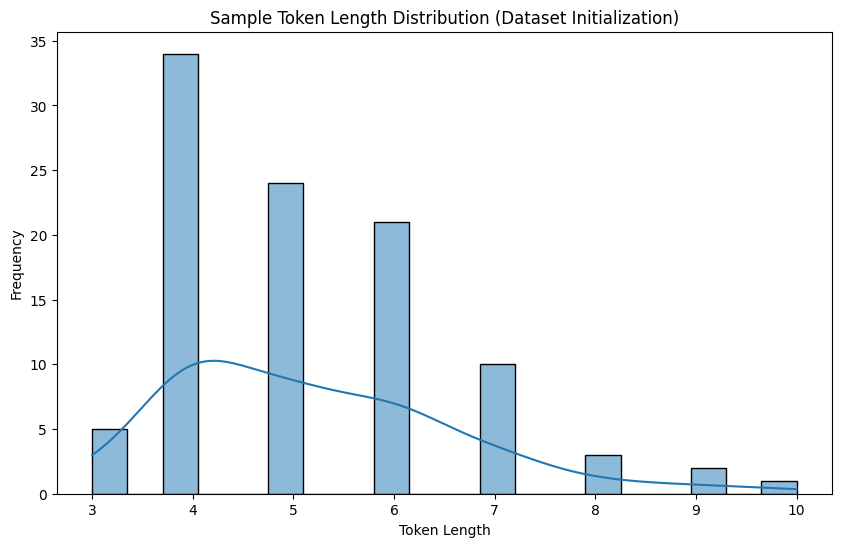

Calculated input size for FC layer: 512


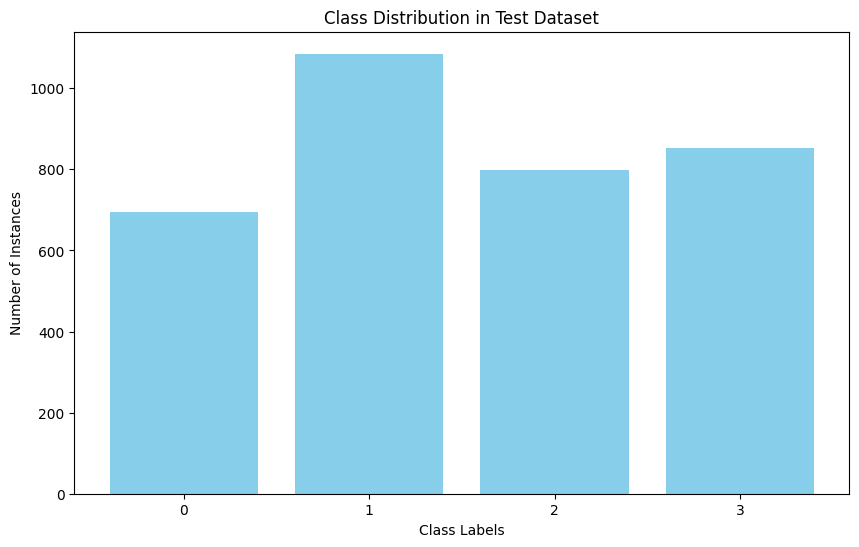

/tmp/ipykernel_3912439/1365449101.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model loaded for testing
Accuracy: 0.8409
Accuracy: 0.8409
Precision: 0.8404
Recall: 0.8409
F1 Score: 0.8402

Classification Report:

              precision    recall  f1-score   support

       Black       0.75      0.74      0.74       695
        Blue       0.83      0.86      0.85      1085
       Green       0.90      0.94      0.92       799
         TTR       0.86      0.81      0.83       852

    accuracy                           0.84      3431
   macro avg       0.84      0.84      0.84      3431
weighted avg       0.84      0.84      0.84      3431



In [ ]:

# Initialize device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define image transformations for the validation and test data (no augmentation, just resizing and normalization):
val_test_image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (same as training data)
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet stats (for compatibility with pre-trained models)
])

# Get file paths for images in testing set
image_paths_test = get_image_paths(TEST_PATH)
# Load text data and corresponding labels for testing set
text_test, labels_test = read_text_files_with_labels(TEST_PATH)
# Load the pre-trained DistilBERT tokenizer for text processing
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create instances of the MultiModalDataset for testing
# Test dataset includes text data, labels, image paths, tokenizer, max sequence length, and image transformation functions
dataset_test = MultiModalDataset(text_test, labels_test, image_paths_test, tokenizer, max_len, val_test_image_transforms)

# Create DataLoader objects for testing
# The DataLoader handles batching, shuffling, and feeding data to the model during training and evaluation
test_loader = DataLoader(dataset_test, batch_size=brench_size, shuffle=False) 

# Initialize the multi-modal classifier model
# `num_classes=4` specifies that the model is for a classification task with 4 classes
# `fc_hidden_sizes` and `dropout_rate` are hyperparameters that define the fully connected layer sizes and dropout rate
model = MultiModalClassifier(num_classes=4, fc_hidden_sizes=fc_hidden_sizes, dropout_rate=dropout_rate).to(device)

# Count the number of instances in the testing data
test_class_counts = count_class_instances(labels_test)

# Plot the distribution of class counts for the testing set
# This helps visualize any class imbalances and check if the oversampling is having the intended effect
plot_class_distribution(test_class_counts, "Test")

# Load the best model for testing
model_path = f'best_model.pth'  # Path to the saved model (trained with BuildModel.py)
model.load_state_dict(torch.load(model_path, map_location=device))  # Load the model weights
model.eval()    # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
print(f"Model loaded for testing")  # Confirmation that the model has been loaded

# Evaluate the model on the test set
test_predictions        = []    # To store predicted labels for the test set
misclassified_samples   = []    # To store any samples that were misclassified for further analysis

with torch.no_grad():   # Disable gradient calculation to save memory and computation during evaluation
    # Iterate through the test data loader
    for batch in test_loader:
        input_ids       = batch['input_ids'].to(device)         # Move tokenized text input to device
        attention_mask  = batch['attention_mask'].to(device)    # Move attention mask to device
        images          = batch['images'].to(device)            # Move images to device

        # Forward pass through the model to get the outputs (logits)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, images=images)

        # Get the predicted class with the highest score for each sample
        _, preds = torch.max(outputs, dim=1)

        # Check if labels are present in batch and collect predictions
        if 'label' in batch:
            labels = batch['label'].to(device)  # Move true labels to device

            # Collect predicted labels (in CPU memory for easier processing)
            test_predictions.extend(preds.cpu().numpy())    # Convert predictions to numpy array and append
            
            # Check if captions exist in the batch (optional field, may not be present in all datasets)
            captions = batch.get('caption', [None] * len(labels))  # Provide a default caption list with None if 'caption' is not available

            # Collect misclassified samples for further analysis (e.g., error analysis)
            for idx, (true_label, pred_label) in enumerate(zip(labels, preds)):
                # If the model's prediction does not match the true label
                if true_label != pred_label:
                    misclassified_samples.append({
                        "filename":         batch['filename'][idx], # Store the filename of the misclassified sample
                        "true_label":       true_label.item(),      # Store the true label
                        "predicted_label":  pred_label.item(),      # Store the predicted label
                        "text":             batch['text'][idx],     # Store the text associated with the misclassified sample
                    })

# Calculate and print accuracy
accuracy = (test_predictions == labels_test).sum() / labels_test.size
print(f"Accuracy: {accuracy:.4f}")

# Evaluate classification metrics and plot confusion matrix
evaluate_classification_metrics(labels_test, test_predictions, class_names=["Black", "Blue", "Green", "TTR"], filename="confusion_matrix.png")
